C:\Users\vango\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Epoch [1/10], Step [100/938], Loss: 0.2326
Epoch [1/10], Step [200/938], Loss: 0.2190
Epoch [1/10], Step [300/938], Loss: 0.2218
Epoch [1/10], Step [400/938], Loss: 0.2172
Epoch [1/10], Step [500/938], Loss: 0.2078
Epoch [1/10], Step [600/938], Loss: 0.2049
Epoch [1/10], Step [700/938], Loss: 0.1963
Epoch [1/10], Step [800/938], Loss: 0.2060
Epoch [1/10], Step [900/938], Loss: 0.2042
Epoch [2/10], Step [100/938], Loss: 0.2054
Epoch [2/10], Step [200/938], Loss: 0.1994
Epoch [2/10], Step [300/938], Loss: 0.2005
Epoch [2/10], Step [400/938], Loss: 0.2027
Epoch [2/10], Step [500/938], Loss: 0.2007
Epoch [2/10], Step [600/938], Loss: 0.1963
Epoch [2/10], Step [700/938], Loss: 0.1904
Epoch [2/10], Step [800/938], Loss: 0.1962
Epoch [2/10], Step [900/938], Loss: 0.2045
Epoch [3/10], Step [100/938], Loss: 0.1990
Epoch [3/10], Step [200/938], Loss: 0.2002
Epoch [3/10], Step [300/938], Loss: 0.1980
Epoch [3/10], Step [400/938], Loss: 0.2060
Epoch [3/10], Step [500/938], Loss: 0.1966
Epoch [3/10

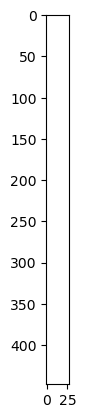

In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple de diffusion simple pour images
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a simple U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the forward diffusion process
def forward_diffusion(x0, t, noise):
    return torch.sqrt(1 - t) * x0 + torch.sqrt(t) * noise

# Define the inverse diffusion process
def inverse_diffusion(model, xt, t):
    pred_noise = model(xt)
    return (xt - torch.sqrt(t) * pred_noise) / torch.sqrt(1 - t)

# Load dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)
        noise = torch.randn_like(images).to(device)
        t = torch.rand(images.size(0), 1, 1, 1).to(device)
        
        noisy_images = forward_diffusion(images, t, noise)
        predicted_noise = model(noisy_images)
        
        loss = criterion(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

# Generate images using the trained model
def generate_images(model, num_images, steps):
    model.eval()
    with torch.no_grad():
        xt = torch.randn(num_images, 1, 28, 28).to(device)
        for t in reversed(torch.linspace(0, 1, steps)):
            xt = inverse_diffusion(model, xt, t)
    return xt.cpu()

# Generate and visualize images
generated_images = generate_images(model, 16, 100)
grid = torch.cat([generated_images[i] for i in range(16)], dim=1).squeeze().numpy()
plt.imshow(grid, cmap='gray')
plt.show()

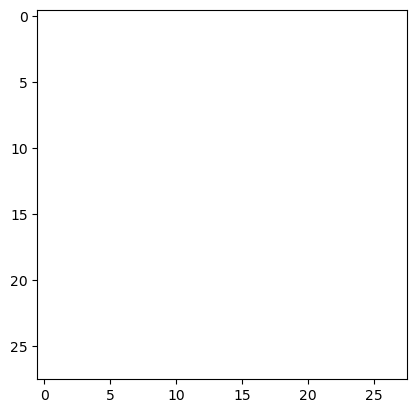

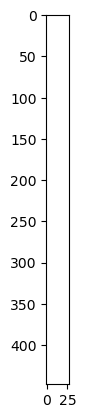

In [4]:
# Generate images using the trained model
def generate_images(model, num_images, steps):
    model.eval()
    with torch.no_grad():
        xt = torch.randn(num_images, 1, 28, 28).to(device)
        for t in reversed(torch.linspace(0, 1, steps)):
            xt = inverse_diffusion(model, xt, t)
    return xt.cpu()

# Generate and visualize images
generated_images = generate_images(model, 16, 100)
plt.imshow(generated_images[0].squeeze().numpy(), cmap='gray')
plt.show()
grid = torch.cat([generated_images[i] for i in range(16)], dim=1).squeeze().numpy()
plt.imshow(grid, cmap='gray')
plt.show()